#True Value Estimation

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [3]:
# Load the netCDF4 data
ds = xr.open_dataset(r'D:\first_project_smart_meteorology\my_data\ERA5_1.nc')

In [4]:
# Convert valid_time to datetime
ds['valid_time'] = pd.to_datetime(ds['valid_time'].values, unit='s')

In [5]:
# Extract mean sea level pressure data
msl = ds['msl'].values

In [32]:
# Reshape the data: (time, lat, lon) -> (time, lat*lon)
msl_reshaped = msl.reshape(msl.shape[0], -1)


In [9]:
# Create a DataFrame
df = pd.DataFrame(msl_reshaped, index=ds['valid_time'].values)


In [10]:
# Normalize the data
scaler = MinMaxScaler()
msl_normalized = scaler.fit_transform(df)

In [11]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 24  # Use 24 time steps to predict the next step
X, y = create_sequences(msl_normalized, seq_length)

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# Build the LSTM model
model = Sequential([
    # First LSTM layer
    LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, msl_reshaped.shape[1])),
    BatchNormalization(),
    Dropout(0.2),
    
    # Second LSTM layer
    LSTM(64, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    
    # Third LSTM layer
    LSTM(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Dense layers
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    # Output layer
    Dense(msl_reshaped.shape[1])
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [36]:

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24, 128)           22809600  
                                                                 
 batch_normalization (BatchN  (None, 24, 128)          512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 24, 64)            49408     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 24, 64)           

In [46]:
# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/60
3/3 [==============================] - 6s 2s/step - loss: 0.0455 - val_loss: 0.0509
Epoch 2/60
3/3 [==============================] - 5s 2s/step - loss: 0.0534 - val_loss: 0.0519
Epoch 3/60
3/3 [==============================] - 5s 2s/step - loss: 0.0452 - val_loss: 0.0526
Epoch 4/60
3/3 [==============================] - 5s 2s/step - loss: 0.0481 - val_loss: 0.0523
Epoch 5/60
3/3 [==============================] - 5s 2s/step - loss: 0.0459 - val_loss: 0.0518
Epoch 6/60
3/3 [==============================] - 5s 2s/step - loss: 0.0489 - val_loss: 0.0522
Epoch 7/60
3/3 [==============================] - 5s 2s/step - loss: 0.0449 - val_loss: 0.0507
Epoch 8/60
3/3 [==============================] - 5s 2s/step - loss: 0.0465 - val_loss: 0.0489
Epoch 9/60
3/3 [==============================] - 5s 2s/step - loss: 0.0510 - val_loss: 0.0475
Epoch 10/60
3/3 [==============================] - 5s 2s/step - loss: 0.0481 - val_loss: 0.0469
Epoch 11/60
3/3 [==============================] 

In [47]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train MSE: {train_loss:.4f}')
print(f'Test MSE: {test_loss:.4f}')

Train MSE: 0.0293
Test MSE: 0.0315


In [48]:
# Make predictions
predictions = model.predict(X_test)
predictions


1/1 [==============================] - 1s 564ms/step


array([[0.45511654, 0.44753066, 0.4422058 , ..., 0.62063813, 0.61398786,
        0.60605896],
       [0.65977955, 0.6601968 , 0.65924245, ..., 0.37489033, 0.36282647,
        0.35539794],
       [0.2903401 , 0.28306434, 0.27788332, ..., 0.48854816, 0.48429346,
        0.47932792],
       ...,
       [0.67624474, 0.6720672 , 0.67038345, ..., 0.4074883 , 0.4072521 ,
        0.4068178 ],
       [0.6472419 , 0.6456713 , 0.6451601 , ..., 0.43534368, 0.43240702,
        0.43049416],
       [0.6803621 , 0.6786922 , 0.6777834 , ..., 0.5366678 , 0.5314591 ,
        0.5286211 ]], dtype=float32)

In [49]:
# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

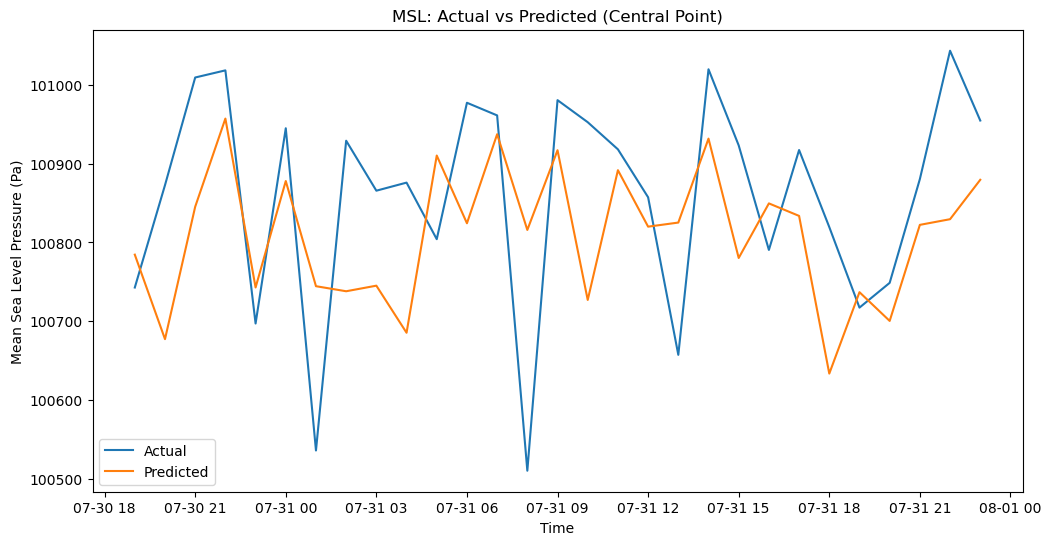

In [50]:
# Plot results for a single point (e.g., central point)
central_point = msl_reshaped.shape[1] // 2
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_actual[:, central_point], label='Actual')
plt.plot(df.index[-len(y_test):], predictions[:, central_point], label='Predicted')
plt.title('MSL: Actual vs Predicted (Central Point)')
plt.xlabel('Time')
plt.ylabel('Mean Sea Level Pressure (Pa)')
plt.legend()
plt.show()

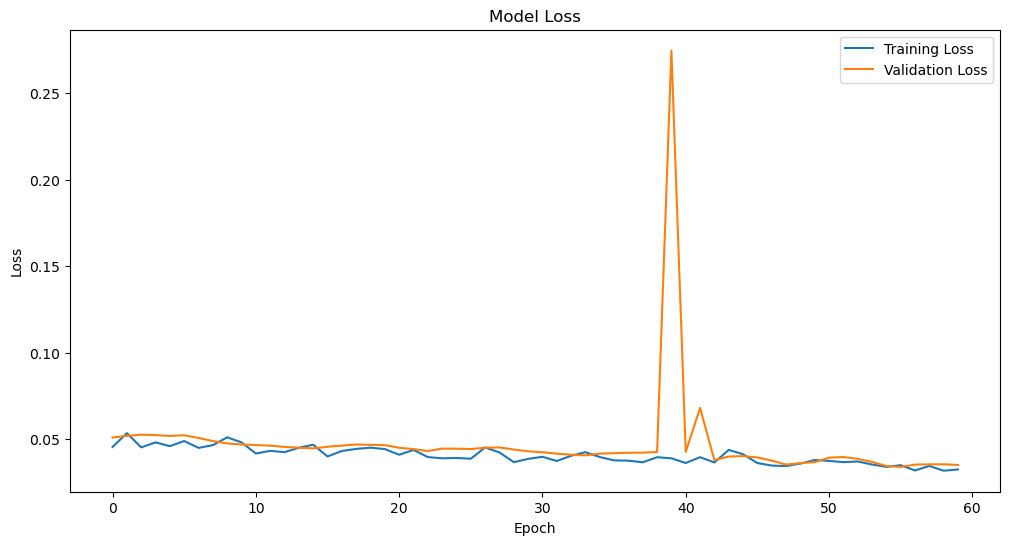

In [51]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

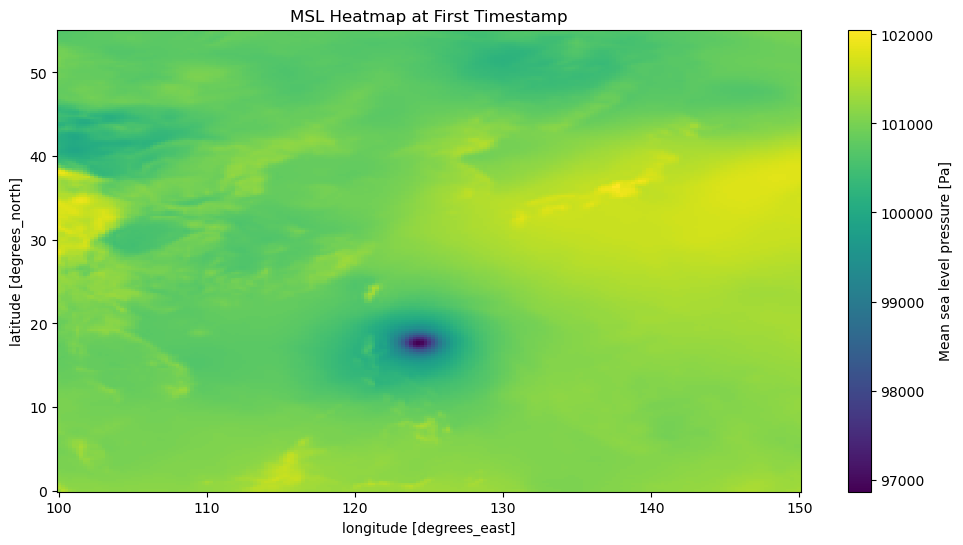

In [52]:
# Plot a heatmap of MSL for a specific time
plt.figure(figsize=(12, 6))
ds['msl'].isel(valid_time=0).plot()
plt.title('MSL Heatmap at First Timestamp')
plt.show()

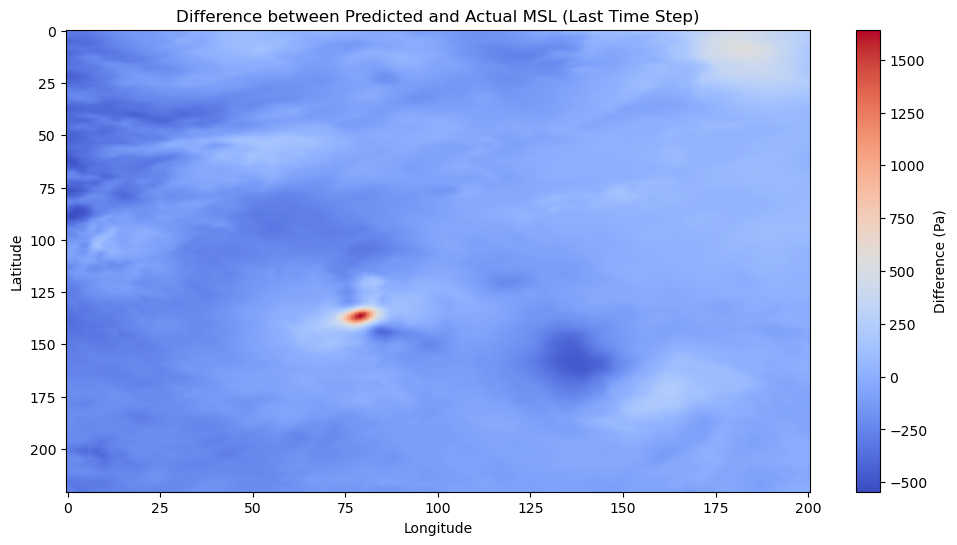

In [53]:
# Plot the difference between predicted and actual for the last time step
last_prediction = predictions[-1].reshape(221, 201)
last_actual = y_test_actual[-1].reshape(221, 201)
difference = last_prediction - last_actual



plt.figure(figsize=(12, 6))
plt.imshow(difference, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Difference (Pa)')
plt.title('Difference between Predicted and Actual MSL (Last Time Step)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()